In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data123344/data_final_s2_300s_1000hz_RT1.pkl
/kaggle/input/data1234/data_final_s2_300s_1000hz_RT1.pkl
/kaggle/input/s2data/data_final_s2_300s_100hz_RT1.pkl
/kaggle/input/adfasdf/data_final_s2_300s_100hz.pkl
/kaggle/input/data-sim/data_final_s2_300s_50hz.pkl
/kaggle/input/asrqw334/data_final_s2_300s_1000hz_RT1purie.pkl


In [3]:
import pandas as pd
import numpy as np 

import tensorflow as tf
from keras import utils as np_utils 

from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, GlobalAveragePooling1D
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import MaxPooling1D

import pickle


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
from sklearn.preprocessing import StandardScaler
df = pd.read_pickle("/kaggle/input/asrqw334/data_final_s2_300s_1000hz_RT1purie.pkl") # index column을 0번째 줄로 정한다는 의미입니다. 

df['label'].value_counts()
df_y=df['label']
df_x=df.drop(['label'],axis=1)

# StandardScaler 객체 생성
scaler = StandardScaler()

# 데이터에 스케일링 적용
scaled_ecg_data = scaler.fit_transform(df_x)

# 스케일링된 데이터를 DataFrame 형태로 변환
scaled_ecg_data_df = pd.DataFrame(scaled_ecg_data, columns=df_x.columns)

# 스케일링된 데이터의 첫 5행을 출력
df = pd.concat([scaled_ecg_data_df, df_y], axis = 1) # 열 방향으로 합치기
df

,0,10,20,30,40,50,60,70,80,90,...,299910,299920,299930,299940,299950,299960,299970,299980,299990,label
0,-0.121425,-0.153621,-0.137197,-0.079641,0.004527,0.105466,0.205734,0.277779,0.312612,0.326413,...,0.145664,0.224034,0.275341,0.296931,0.303125,0.313391,0.337915,0.373632,0.405474,0
1,-0.850215,-0.656674,-0.486775,-0.357359,-0.259745,-0.180576,-0.113542,-0.061668,-0.025753,0.001937,...,1.111193,1.514271,1.371701,0.666956,-0.277324,-1.013283,-1.282096,-1.108275,-0.694109,0
2,-0.774890,-0.410718,-0.262141,-0.254733,-0.282621,-0.270663,-0.187035,-0.058115,0.059245,0.135592,...,0.063926,0.058950,0.057320,0.062221,0.073241,0.084858,0.089320,0.082496,0.069078,0
3,-0.434417,-0.618725,-0.504316,0.007421,0.878193,1.859747,2.412315,2.040309,0.876757,-0.495578,...,0.134534,0.099904,0.050251,0.004728,-0.018111,-0.010911,0.021295,0.066147,0.107148,0
4,0.096915,0.056650,0.036289,0.059532,0.136561,0.256338,0.372464,0.418574,0.365743,0.222689,...,0.302507,0.318245,0.329591,0.343026,0.368703,0.413589,0.471217,0.514985,0.492317,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2352,0.760982,0.773923,0.813330,0.901016,1.044181,1.212611,1.311527,1.234830,0.966186,0.541337,...,-0.247869,0.095580,0.378513,0.428709,0.170164,-0.289471,-0.718661,-0.903652,-0.756245,1
2353,0.142348,0.189032,0.290411,0.425004,0.561072,0.649286,0.618627,0.434719,0.146216,-0.177754,...,-0.011316,0.029158,0.052132,0.053570,0.041552,0.029028,0.023160,0.023325,0.027928,1
2354,-0.168700,-0.127698,-0.021949,0.141424,0.348031,0.562605,0.703159,0.683174,0.504236,0.230034,...,0.066577,0.035796,0.008621,0.013989,0.079100,0.211590,0.390806,0.569724,0.675755,1
2355,-0.069814,-0.095461,-0.079924,-0.003171,0.135666,0.310493,0.448537,0.459522,0.321520,0.077945,...,-0.381329,-0.737645,-0.790988,-0.540357,-0.147890,0.189281,0.367187,0.392698,0.330345,1


In [5]:
# train_test를 분리합니다. 
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size = 0.1, stratify = df['label'])
print(train_df.shape, valid_df.shape)

(2121, 30001) (236, 30001)


In [6]:
train_df['label'].value_counts()

1    1063
0    1058
Name: label, dtype: int64

In [7]:
batch_size = 8
epochs = 100

## 조심 
patience = 30 # earlystop 할 때 조절하는 것 
## 고정
data_len = len(df.iloc[0]) - 1

In [8]:
# dataset, dataloader

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = 32, train = False):
        self.df = df.reset_index(drop=True)
        self.train = train
        self.batch_size = batch_size
    
    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)
    
    def on_epoch_end(self):
        if self.train: # Reshuffle train on end of epoch
            self.df = self.df.sample(frac=1.0).reset_index(drop=True)
            
    def __getitem__(self, idx):
        batch_x = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size, :-1].values # batch_size, 30000
        batch_y = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size].label.values # batch_size, 1

        X = np.zeros((batch_x.shape[0], data_len))
        
        # train -> augmentation O
        if self.train:
          for i in range(batch_x.shape[0]): # i = 0, 1, 2, ,,, , 31
            X[i] = batch_x[i] + np.random.normal(0, 0.05, size = (data_len,)) 
        
        # valid -> augmentation X
        else:
          X = batch_x

        # X의 차원을 늘려줍니다. <- model 들어갈 때 error 뜸
        X = tf.expand_dims(X,2)

        return X, batch_y 

In [9]:
train_ds = DataGenerator(train_df, batch_size = batch_size, train = False)
valid_ds = DataGenerator(valid_df, batch_size = batch_size, train = False)

for x_train, y_train in train_ds:
  print(x_train.shape)
  print(y_train.shape)
  break
y_train

(8, 30000, 1)
(8,)


array([0, 0, 1, 1, 0, 1, 1, 1])

In [10]:
def network_v3():

    # 마지막 차원 추가해줌 위에서
    x = Input(shape = (data_len, 1), name='inputs_cnn')

    # Conv1D
    y = Convolution1D(16, 55, activation = 'leaky_relu')(x)
    y = BatchNormalization()(y)
    y = MaxPool1D(10)(y)
    y = Dropout(0.2)(y)
    
    y = Convolution1D(32, 55, activation = 'leaky_relu')(x)
    y = BatchNormalization()(y)
    y = MaxPool1D(10)(y)
    y = Dropout(0.2)(y)

    y = Convolution1D(64, 25, activation = 'leaky_relu')(y)
    y = BatchNormalization()(y)
    y = MaxPool1D(5)(y)
    y = Dropout(0.2)(y)

    y = Convolution1D(128, 10, activation = 'leaky_relu')(y)
    y = BatchNormalization()(y)
    y = MaxPool1D(5)(y)
    y = Dropout(0.2)(y)

    y = Convolution1D(256, 10, activation = 'leaky_relu')(y)
    y = BatchNormalization()(y)
    y = MaxPool1D(5)(y)
    y = Dropout(0.2)(y)

    y = Convolution1D(512, 9, activation = 'leaky_relu')(y)

    # GAP
    y = GlobalAveragePooling1D()(y)

    # Dense
    y = Dense(32, activation='leaky_relu')(y)
    
    y = Dense(1, activation='sigmoid', name='main_output')(y) 

    # Model
    model = Model(x, y)

    # return
    return model

model = network_v3()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 30000, 1)]        0         
                                                                 
 conv1d_1 (Conv1D)           (None, 29946, 32)         1792      
                                                                 
 batch_normalization_1 (Batc  (None, 29946, 32)        128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2994, 32)         0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 2994, 32)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 2970, 64)          51264 

In [11]:
# compile

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model.compile(loss = loss, optimizer = optimizer, metrics = ['acc'])

es = EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights=True)

In [12]:
# history_v1 = model.fit(train_ds, epochs = epochs, validation_data = valid_ds, callbacks = [es])
history_v1 = model.fit(train_ds, epochs = epochs, validation_data = valid_ds)

Epoch 1/100
266/266 [==============================] - 25s 26ms/step - loss: 0.9469 - acc: 0.5182 - val_loss: 1.0669 - val_acc: 0.5085
Epoch 2/100
266/266 [==============================] - 6s 24ms/step - loss: 0.7453 - acc: 0.5549 - val_loss: 0.7615 - val_acc: 0.5339
Epoch 3/100
266/266 [==============================] - 6s 23ms/step - loss: 0.7322 - acc: 0.5474 - val_loss: 0.7426 - val_acc: 0.5424
Epoch 4/100
266/266 [==============================] - 6s 23ms/step - loss: 0.7387 - acc: 0.5568 - val_loss: 0.7059 - val_acc: 0.5085
Epoch 5/100
266/266 [==============================] - 6s 23ms/step - loss: 0.6836 - acc: 0.5752 - val_loss: 0.6518 - val_acc: 0.5847
Epoch 6/100
266/266 [==============================] - 6s 23ms/step - loss: 0.7110 - acc: 0.5856 - val_loss: 1.3669 - val_acc: 0.5042
Epoch 7/100
266/266 [==============================] - 6s 24ms/step - loss: 0.7429 - acc: 0.5545 - val_loss: 0.6733 - val_acc: 0.5593
Epoch 8/100
266/266 [==============================] - 6s 23m

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def show_lcurve(hists, titles, colors=["r","g","b","k"], size=(12,4), x_itv=1, lw=1):
    plt.figure(figsize=size)
    plt.style.use("seaborn-white")
    # loss 
    plt.subplot(121)
    for i, hist in enumerate(hists):
        loss = hist.history['loss']
        val_loss = hist.history['val_loss']
        epochs = range(1, 1+len(loss))
        xbins = range(0, len(loss)+1, x_itv)
        plt.plot(epochs, loss, lw=lw,linestyle=':', label=f'{titles[i]} train loss', c=colors[i])
        plt.plot(epochs, val_loss, lw=lw,marker='.', label=f'{titles[i]} valid loss', c=colors[i])
        plt.legend();plt.grid(True);plt.xticks(xbins)
        plt.xlabel('Epochs');plt.ylabel('Loss')
        x, y = epochs[-1], hist.history['loss'][-1]
        plt.text(x, y, np.round(y,2), c=colors[i])
        x, y = epochs[-1], hist.history['val_loss'][-1]
        plt.text(x, y, np.round(y,2), c=colors[i])

    # acc
    plt.subplot(122)
    for i, hist in enumerate(hists):
        acc = hist.history['acc']
        val_acc = hist.history['val_acc']
        plt.plot(epochs, acc, linestyle=':', lw=lw,label=f'{titles[i]} train acc', c=colors[i])
        plt.plot(epochs, val_acc, marker='.', lw=lw,label=f'{titles[i]} valid acc', c=colors[i])
        plt.legend();plt.grid(True);plt.xticks(xbins)
        plt.xlabel('Epochs');plt.ylabel('Acc')
        x, y = epochs[-1], hist.history['acc'][-1]
        plt.text(x, y, np.round(y,2), c=colors[i])
        x, y = epochs[-1], hist.history['val_acc'][-1]
        plt.text(x, y, np.round(y,2), c=colors[i])
    plt.show()

/tmp/ipykernel_29/248836811.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


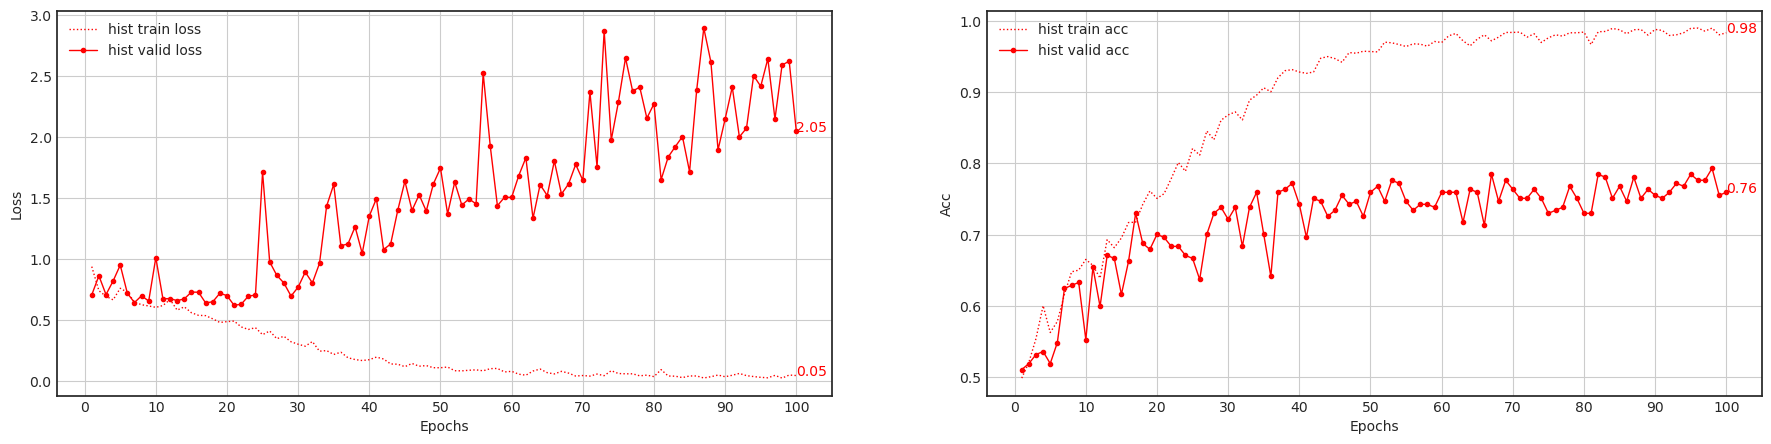

In [14]:
show_lcurve([history_v1], ["hist"], size = (22, 5), x_itv = 10 ) # x_itv: epoch 몇번씩 볼 수 있는지